### <b> PySpark vs GCP </b>

#### <b> PySpark </b>

In [104]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr, when, datediff, hour, minute, count, avg, stddev, min, max, desc, countDistinct
import os
import time
import matplotlib.pyplot as plt

In [3]:
import psutil

# Print your system's available memory
mem_info = psutil.virtual_memory()
print(f"Total memory: {mem_info.total / (1024**3):.2f} GB")
print(f"Available memory: {mem_info.available / (1024**3):.2f} GB")

Total memory: 18.00 GB
Available memory: 8.70 GB


* <b> Java is required: </b> brew install openjdk@11 (MacOs) OR sudo apt install openjdk-11-jdk (Ubuntu)


#### <b> Spark and CSV data loading functions </b>

In [4]:
# spark.driver.memory: Used by the main program that orchestrates tasks (Stores task results, coordinates actions, loads final DataFrames)
# spark.executor.memory: Used by worker processes that execute individual tasks (Data processing, transformations, aggregations, shuffling)
# spark.driver.maxResultSize: limits the total size of serialized results that can be returned to the driver from all partitions in a single Spark operation
def initialize_spark():
    '''
    Description: Initialize Spark Session

    Arguments: 
        -None
    Output: 
        -Spark session
    '''
    spark = SparkSession.builder \
                        .appName("MIMIC-III LOS Prediction") \
                        .config("spark.driver.memory", "12g") \
                        .config("spark.executor.memory", "12g") \
                        .config("spark.driver.maxResultSize", "6g") \
                        .getOrCreate()

    # Check initialization
    print("Success! Spark is working.")
    print(f"Spark version: {spark.version}\n")

    return spark

def load_csv_table(spark, csv_dir, table_name):
    """Load a CSV table with performance timing."""
    csv_path = os.path.join(csv_dir, f"{table_name.upper()}.csv")
    
    print(f"Loading {table_name} from CSV...")
    start_time = time.time()
    
    
    df = spark.read.csv(csv_path, header=True, inferSchema=True)
    df = df.drop("ROW_ID")
    
    # Force action to measure full load time
    count = df.count()
    end_time = time.time()
    
    print(f"Loaded {table_name}: {count} rows in {end_time - start_time:.2f} seconds")
    return df

In [5]:
spark = initialize_spark()

init_time = time.time()

# Load tables
admissions_df = load_csv_table(spark, "../data/raw", "admissions")
print("\n")
callout_df = load_csv_table(spark, "../data/raw", "callout")
print("\n")
chart_events_df = load_csv_table(spark, "../data/raw", "chartevents")
print("\n")
d_icd_diagnoses = load_csv_table(spark, "../data/raw", "d_icd_diagnoses")
print("\n")
d_items_df = load_csv_table(spark, "../data/raw", "d_items")
print("\n")
diagnoses_icd_df = load_csv_table(spark, "../data/raw", "diagnoses_icd")
print("\n")
icustays_df = load_csv_table(spark, "../data/raw", "icustays")
print("\n")
patients_df = load_csv_table(spark, "../data/raw", "patients")
print("\n")
services_df = load_csv_table(spark, "../data/raw", "services")
print("\n")

final_time = time.time() - init_time

print(f"Total loading time: {final_time}")

25/06/03 14:28:59 WARN Utils: Your hostname, MacBook-Pro-de-Rodrigo.local resolves to a loopback address: 127.0.0.1; using 172.17.18.15 instead (on interface en0)
25/06/03 14:28:59 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/03 14:28:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Success! Spark is working.
Spark version: 3.5.5

Loading admissions from CSV...
Loaded admissions: 58976 rows in 3.02 seconds


Loading callout from CSV...
Loaded callout: 34499 rows in 0.30 seconds


Loading chartevents from CSV...


Loaded chartevents: 330712483 rows in 88.49 seconds


Loading d_icd_diagnoses from CSV...
Loaded d_icd_diagnoses: 14567 rows in 0.12 seconds


Loading d_items from CSV...
Loaded d_items: 12487 rows in 0.13 seconds


Loading diagnoses_icd from CSV...
Loaded diagnoses_icd: 651047 rows in 0.29 seconds


Loading icustays from CSV...
Loaded icustays: 61532 rows in 0.15 seconds


Loading patients from CSV...
Loaded patients: 46520 rows in 0.12 seconds


Loading services from CSV...
Loaded services: 73343 rows in 0.17 seconds


Total loading time: 92.79729104042053


In [6]:
chart_events_df.show(5)

+----------+-------+----------+------+-------------------+-------------------+-----+-----+--------+--------+-------+-----+------------+-------+
|SUBJECT_ID|HADM_ID|ICUSTAY_ID|ITEMID|          CHARTTIME|          STORETIME| CGID|VALUE|VALUENUM|VALUEUOM|WARNING|ERROR|RESULTSTATUS|STOPPED|
+----------+-------+----------+------+-------------------+-------------------+-----+-----+--------+--------+-------+-----+------------+-------+
|        36| 165660|    241249|223834|2134-05-12 12:00:00|2134-05-12 13:56:00|17525|   15|    15.0|   L/min|      0|    0|        NULL|   NULL|
|        36| 165660|    241249|223835|2134-05-12 12:00:00|2134-05-12 13:56:00|17525|  100|   100.0|    NULL|      0|    0|        NULL|   NULL|
|        36| 165660|    241249|224328|2134-05-12 12:00:00|2134-05-12 12:18:00|20823|  .37|    0.37|    NULL|      0|    0|        NULL|   NULL|
|        36| 165660|    241249|224329|2134-05-12 12:00:00|2134-05-12 12:19:00|20823|    6|     6.0|     min|      0|    0|        NULL| 

#### <b> Join tables based on the MIMIC-III dataset structure</b>

* 1 patient can have multiple ICU stays and Admissions
* We can extract total Hospital LOS by subtracting DISCHTIME to ADMITTIME
* We also can extract total ICU LOS

In [7]:
# Let's examine the multiple ICU stays situation
def analyze_multiple_icu_stays(icustays_df):
    """
    Analyze patterns of multiple ICU stays in the dataset.
    """
    print("=== Analysis of Multiple ICU Stays ===")
    
    # Total ICU stays
    total_stays = icustays_df.count()
    print(f"Total ICU stays: {total_stays}")
    
    # Unique patients
    unique_patients = icustays_df.select("SUBJECT_ID").distinct().count()
    print(f"Unique patients: {unique_patients}")
    
    # Unique hospital admissions
    unique_admissions = icustays_df.select("HADM_ID").distinct().count()
    print(f"Unique hospital admissions: {unique_admissions}")
    
    # Patients with multiple ICU stays (any combination)
    patients_multiple_stays = icustays_df.groupBy("SUBJECT_ID") \
        .agg(count("ICUSTAY_ID").alias("icu_stays_count")) \
        .filter("icu_stays_count > 1")
    
    multiple_stays_count = patients_multiple_stays.count()
    print(f"Patients with multiple ICU stays: {multiple_stays_count}")
    
    # Distribution of ICU stays per patient
    print("\nDistribution of ICU stays per patient:")
    icustays_df.groupBy("SUBJECT_ID") \
        .agg(count("ICUSTAY_ID").alias("stays_count")) \
        .groupBy("stays_count") \
        .agg(count("SUBJECT_ID").alias("patient_count")) \
        .orderBy("stays_count") \
        .show()
    
    
    # Multiple ICU stays within same hospital admission
    same_admission_multiple = icustays_df.groupBy("HADM_ID") \
        .agg(count("ICUSTAY_ID").alias("icu_stays_in_admission")) \
        .filter("icu_stays_in_admission > 1")
    
    same_admission_count = same_admission_multiple.count()
    print(f"Hospital admissions with multiple ICU stays: {same_admission_count}")
    
    # Show examples
    print("\nExamples of patients with multiple ICU stays:")
    icustays_df.join(patients_multiple_stays.limit(3), "SUBJECT_ID") \
        .select("SUBJECT_ID", "HADM_ID", "ICUSTAY_ID", "INTIME", "OUTTIME", "LOS") \
        .orderBy("SUBJECT_ID", "INTIME") \
        .show(truncate=False)
    
    return {
        "total_stays": total_stays,
        "unique_patients": unique_patients,
        "patients_with_multiple_stays": multiple_stays_count,
        "admissions_with_multiple_icu_stays": same_admission_count
    }



# Run the analysis
stats = analyze_multiple_icu_stays(icustays_df)

=== Analysis of Multiple ICU Stays ===
Total ICU stays: 61532
Unique patients: 46476
Unique hospital admissions: 57786
Patients with multiple ICU stays: 8755

Distribution of ICU stays per patient:
+-----------+-------------+
|stays_count|patient_count|
+-----------+-------------+
|          1|        37721|
|          2|         5796|
|          3|         1619|
|          4|          650|
|          5|          300|
|          6|          151|
|          7|           86|
|          8|           44|
|          9|           29|
|         10|           19|
|         11|           15|
|         12|           11|
|         13|            8|
|         14|            4|
|         15|            6|
|         16|            2|
|         17|            2|
|         18|            2|
|         20|            1|
|         21|            2|
+-----------+-------------+
only showing top 20 rows

Hospital admissions with multiple ICU stays: 3260

Examples of patients with multiple ICU stays:
+------

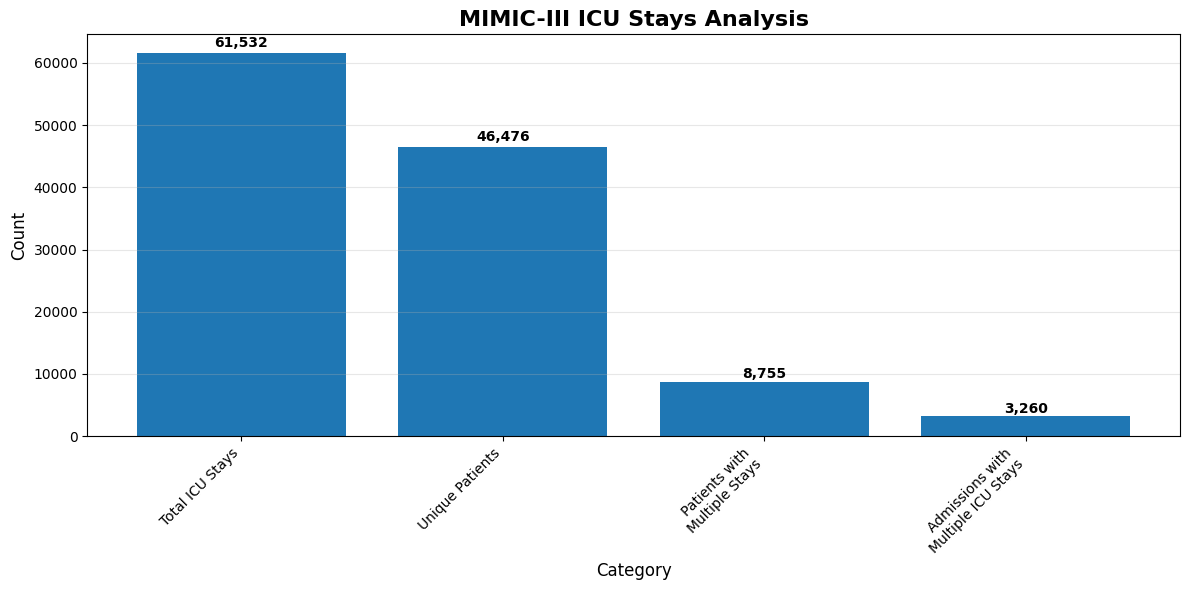

In [8]:
import matplotlib.pyplot as plt

xx = []
total_stays = stats["total_stays"]
xx.append(total_stays)
unique_patients = stats["unique_patients"]
xx.append(unique_patients)
patients_with_multiple_stays = stats["patients_with_multiple_stays"]
xx.append(patients_with_multiple_stays)
admissions_with_multiple_icu_stays = stats["admissions_with_multiple_icu_stays"]
xx.append(admissions_with_multiple_icu_stays)

# Create labels for the x-axis
labels = ['Total ICU Stays', 'Unique Patients', 'Patients with\nMultiple Stays', 'Admissions with\nMultiple ICU Stays']
# Create values for the y-axis (your actual data)
values = xx

# Create the bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(labels, values)

# Add value labels on top of each bar - using a fixed offset instead of percentage
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + bar.get_height()*0.01, 
             f'{value:,}', ha='center', va='bottom', fontweight='bold')

# Customize the plot
plt.title('MIMIC-III ICU Stays Analysis', fontsize=16, fontweight='bold')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Category', fontsize=12)

# Rotate x-axis labels if needed for better readability
plt.xticks(rotation=45, ha='right')

# Add grid for better readability
plt.grid(axis='y', alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

In [9]:
stats

{'total_stays': 61532,
 'unique_patients': 46476,
 'patients_with_multiple_stays': 8755,
 'admissions_with_multiple_icu_stays': 3260}

Let's join <b> ICUSTAYS and ADMISSIONS </b> table to get relevant information from patients that were admitted to the ICU when they went to the hospital, and exclude those that didn't

In [10]:
new_icustays_df = icustays_df.join(admissions_df, on=["SUBJECT_ID", "HADM_ID"], how="left")

Now we join the <b> complete ICU data with the PATIENTS info </b>

In [11]:
patients_full_info_df = new_icustays_df.join(patients_df, on="SUBJECT_ID", how="left")

In [12]:
columns=["DOD_HOSP", "DOD_SSN"]
patients_full_info_df = patients_full_info_df.drop(*columns) # redundant since DOD column gives us the same info

In [13]:
patients_full_info_df.show(5)

25/06/03 14:30:35 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+-------+----------+----------+--------------+-------------+------------+-----------+-------------------+-------------------+------+-------------------+-------------------+-------------------+--------------+--------------------+--------------------+---------+--------+-----------------+--------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+------+-------------------+-------------------+-----------+
|SUBJECT_ID|HADM_ID|ICUSTAY_ID|  DBSOURCE|FIRST_CAREUNIT|LAST_CAREUNIT|FIRST_WARDID|LAST_WARDID|             INTIME|            OUTTIME|   LOS|          ADMITTIME|          DISCHTIME|          DEATHTIME|ADMISSION_TYPE|  ADMISSION_LOCATION|  DISCHARGE_LOCATION|INSURANCE|LANGUAGE|         RELIGION|MARITAL_STATUS|           ETHNICITY|          EDREGTIME|          EDOUTTIME|           DIAGNOSIS|HOSPITAL_EXPIRE_FLAG|HAS_CHARTEVENTS_DATA|GENDER|                DOB|                DOD|EXPIRE_FLAG|
+-------

In [14]:
# Check if row counts are the same
print(f"ICUSTAYS count: {icustays_df.count()}")
print(f"After joining ADMISSIONS: {new_icustays_df.count()}")
print(f"After joining PATIENTS: {patients_full_info_df.count()}")


ICUSTAYS count: 61532
After joining ADMISSIONS: 61532
After joining PATIENTS: 61532


In [15]:
d_icd_diagnoses.show(5)

+---------+--------------------+--------------------+
|ICD9_CODE|         SHORT_TITLE|          LONG_TITLE|
+---------+--------------------+--------------------+
|    01166|TB pneumonia-oth ...|Tuberculous pneum...|
|    01170|TB pneumothorax-u...|Tuberculous pneum...|
|    01171|TB pneumothorax-n...|Tuberculous pneum...|
|    01172|TB pneumothorx-ex...|Tuberculous pneum...|
|    01173|TB pneumothorax-m...|Tuberculous pneum...|
+---------+--------------------+--------------------+
only showing top 5 rows



Join the <b> DIAGNOSES and D_ICD_DIAGNOSES tables </b> to get diagnoses descriptions based on the ICD9 code

In [16]:
full_diagnosis_data = diagnoses_icd_df.join(d_icd_diagnoses, on="ICD9_CODE", how="left")
full_diagnosis_data = full_diagnosis_data.drop("SHORT_TITLE")

Check total distinct number of diagnosis

In [58]:
full_diagnosis_data.select("ICD9_CODE").distinct().count()

6985

In [17]:
p_268 = full_diagnosis_data[full_diagnosis_data["SUBJECT_ID"]==268]

In [18]:
p_268.show() # 1 patient can have multiple diagnoses for the same HADM

+---------+----------+-------+-------+--------------------+
|ICD9_CODE|SUBJECT_ID|HADM_ID|SEQ_NUM|          LONG_TITLE|
+---------+----------+-------+-------+--------------------+
|    48241|       268| 110404|      1|Methicillin susce...|
|     4280|       268| 110404|      2|Congestive heart ...|
|    51881|       268| 110404|      3|Acute respiratory...|
|     5845|       268| 110404|      4|Acute kidney fail...|
|     4275|       268| 110404|      5|      Cardiac arrest|
|     0389|       268| 110404|      6|Unspecified septi...|
|    49322|       268| 110404|      7|Chronic obstructi...|
|     2761|       268| 110404|      8|Hyposmolality and...|
|     4271|       268| 110404|      9|Paroxysmal ventri...|
+---------+----------+-------+-------+--------------------+



In [19]:
yo = p_268[p_268["SEQ_NUM"]==1]

In [20]:
title = yo["LONG_TITLE"]

In [21]:
yo.select("LONG_TITLE").collect()[0][0]

'Methicillin susceptible pneumonia due to Staphylococcus aureus'

In [22]:
yo.select("LONG_TITLE").first()[0]

'Methicillin susceptible pneumonia due to Staphylococcus aureus'

In [23]:
full_diagnosis_data.show(5)

+---------+----------+-------+-------+--------------------+
|ICD9_CODE|SUBJECT_ID|HADM_ID|SEQ_NUM|          LONG_TITLE|
+---------+----------+-------+-------+--------------------+
|    40301|       109| 172335|      1|Hypertensive chro...|
|      486|       109| 172335|      2|Pneumonia, organi...|
|    58281|       109| 172335|      3|Chronic glomerulo...|
|     5855|       109| 172335|      4|Chronic kidney di...|
|     4254|       109| 172335|      5|Other primary car...|
+---------+----------+-------+-------+--------------------+
only showing top 5 rows



Now join <b> PATIENT and DIAGNOSES </b> data

In [24]:
patients_full_info_df = patients_full_info_df.join(full_diagnosis_data, on=["SUBJECT_ID","HADM_ID"], how="left")

In [25]:
patients_full_info_df.show(5)

+----------+-------+----------+--------+--------------+-------------+------------+-----------+-------------------+-------------------+-----+-------------------+-------------------+-------------------+--------------+--------------------+------------------+---------+--------+--------+--------------+------------------+-------------------+-------------------+---------+--------------------+--------------------+------+-------------------+-------------------+-----------+---------+-------+--------------------+
|SUBJECT_ID|HADM_ID|ICUSTAY_ID|DBSOURCE|FIRST_CAREUNIT|LAST_CAREUNIT|FIRST_WARDID|LAST_WARDID|             INTIME|            OUTTIME|  LOS|          ADMITTIME|          DISCHTIME|          DEATHTIME|ADMISSION_TYPE|  ADMISSION_LOCATION|DISCHARGE_LOCATION|INSURANCE|LANGUAGE|RELIGION|MARITAL_STATUS|         ETHNICITY|          EDREGTIME|          EDOUTTIME|DIAGNOSIS|HOSPITAL_EXPIRE_FLAG|HAS_CHARTEVENTS_DATA|GENDER|                DOB|                DOD|EXPIRE_FLAG|ICD9_CODE|SEQ_NUM|      

In [64]:
distinct_diagnosis = patients_full_info_df.select("LONG_TITLE").distinct()

In [66]:
distinct_diagnosis.count()

6803

In [65]:
distinct_diagnosis.show()

+--------------------+
|          LONG_TITLE|
+--------------------+
|Closed fracture o...|
|Coronary atherosc...|
|Fetal growth reta...|
|Fall from other s...|
|Atherosclerosis o...|
|Fistula of bile duct|
|Ulcerative (chron...|
|Intestinal bypass...|
|Striking against ...|
|Open fracture of ...|
|Chronic combined ...|
|Malignant neoplas...|
|Closed fracture o...|
|Unspecified cataract|
|Benign paroxysmal...|
|Intermittent expl...|
|Pneumonia due to ...|
|Disorders of phos...|
|Secondary maligna...|
|Influenza with pn...|
+--------------------+
only showing top 20 rows



In [26]:
patients_full_info_df.count()

705921

In [68]:
# Get top N most frequent diagnoses
top_diagnoses = diagnoses_icd_df.groupBy("ICD9_CODE").count() \
    .orderBy(desc("count")).limit(200)  # Top 200 covers ~80% of cases

In [84]:
rare_diagnoses = diagnoses_icd_df.groupBy("ICD9_CODE").count() \
    .filter(col("count") <= 4000) \
    .orderBy(desc("count"))

In [86]:
rare_diagnoses.show(200)

+---------+-----+
|ICD9_CODE|count|
+---------+-----+
|    99592| 3912|
|    V5861| 3806|
|     0389| 3725|
|     5070| 3680|
|    V3000| 3566|
|     5859| 3435|
|      311| 3431|
|    40390| 3421|
|     3051| 3358|
|      412| 3278|
|     2875| 3065|
|    V4581| 3056|
|    41071| 3055|
|     2761| 3039|
|     4240| 2926|
|    V1582| 2811|
|    V3001| 2758|
|     5119| 2734|
|    V4582| 2725|
|    40391| 2630|
|    78552| 2586|
|     4241| 2550|
|    V5867| 2538|
|    42789| 2453|
|    32723| 2380|
|     9971| 2343|
|     5845| 2287|
|     2760| 2272|
|     7742| 2264|
|    49390| 2195|
|     2767| 2169|
|     5180| 2165|
|     4168| 2148|
|    45829| 2121|
|     2749| 2082|
|     4589| 2051|
|     V502| 2016|
|    73300| 1947|
|    78039| 1934|
|     5856| 1926|
|     4271| 1811|
|     5185| 1807|
|     4254| 1709|
|     4111| 1663|
|    V1251| 1612|
|     3572| 1584|
|    30000| 1580|
|    99811| 1535|
|    27800| 1511|
|    E8798| 1502|
|    41400| 1494|
|    60000| 1490|
|     7907

In [27]:
from pyspark.sql.functions import when, max as spark_max, col, count

def fix_diagnosis_duplicates_with_features(patients_full_info_df):
    """
    Create binary features for major diagnosis categories.
    """
    print("Fixing duplicates by creating diagnosis features...")
    
    # Get base data without diagnoses
    base_cols = [col_name for col_name in patients_full_info_df.columns 
                 if col_name not in ["ICD9_CODE", "LONG_TITLE", "SEQ_NUM"]]
    base_data = patients_full_info_df.select(*base_cols).distinct()
    
    # Create binary features for major diagnosis categories
    diagnosis_features = patients_full_info_df.filter(col("ICD9_CODE").isNotNull()) \
        .withColumn("has_cardiac", 
                   when(col("LONG_TITLE").rlike("(?i)(cardiac|heart|myocardial|coronary)"), 1).otherwise(0)) \
        .withColumn("has_respiratory", 
                   when(col("LONG_TITLE").rlike("(?i)(respiratory|pneumonia|copd|lung)"), 1).otherwise(0)) \
        .withColumn("has_renal", 
                   when(col("LONG_TITLE").rlike("(?i)(renal|kidney)"), 1).otherwise(0)) \
        .withColumn("has_infectious", 
                   when(col("LONG_TITLE").rlike("(?i)(sepsis|septic|infection)"), 1).otherwise(0)) \
        .withColumn("has_diabetes", 
                   when(col("LONG_TITLE").rlike("(?i)(diabetes|diabetic)"), 1).otherwise(0)) \
        .withColumn("has_stroke", 
                   when(col("LONG_TITLE").rlike("(?i)(stroke|cerebral)"), 1).otherwise(0)) \
        .withColumn("has_trauma", 
                   when(col("LONG_TITLE").rlike("(?i)(trauma|fracture|injury)"), 1).otherwise(0)) \
        .groupBy("ICUSTAY_ID") \
        .agg(
            spark_max("has_cardiac").alias("has_cardiac"),
            spark_max("has_respiratory").alias("has_respiratory"), 
            spark_max("has_renal").alias("has_renal"),
            spark_max("has_infectious").alias("has_infectious"),
            spark_max("has_diabetes").alias("has_diabetes"),
            spark_max("has_stroke").alias("has_stroke"),
            spark_max("has_trauma").alias("has_trauma"),
            count("ICD9_CODE").alias("total_diagnoses")
        )
    
    # Join with base data
    result = base_data.join(diagnosis_features, on="ICUSTAY_ID", how="left")
    
    print(f"Rows after creating diagnosis features: {result.count()}")
    return result

# Apply the fix
patients_full_info_fixed = fix_diagnosis_duplicates_with_features(patients_full_info_df)

Fixing duplicates by creating diagnosis features...
Rows after creating diagnosis features: 61532


In [95]:
stroke = patients_full_info_fixed[patients_full_info_fixed["has_stroke"] == 1]

In [98]:
stroke.distinct().count()

6869

In [59]:
def analyze_diagnosis_coverage(patients_full_info_df):
    """
    Analyze how much of the diagnosis data our current categories capture.
    """
    print("=== Diagnosis Coverage Analysis ===")
    
    # Get total diagnosis entries
    total_diagnoses = patients_full_info_df.filter(col("ICD9_CODE").isNotNull()).count()
    print(f"Total diagnosis entries: {total_diagnoses:,}")
    
    # Check coverage for each of our current categories
    current_categories = {
        'cardiac': "(?i)(cardiac|heart|myocardial|coronary)",
        'respiratory': "(?i)(respiratory|pneumonia|copd|lung)",
        'renal': "(?i)(renal|kidney)",
        'infectious': "(?i)(sepsis|septic|infection)",
        'diabetes': "(?i)(diabetes|diabetic)",
        'stroke': "(?i)(stroke|cerebral)",
        'trauma': "(?i)(trauma|fracture|injury)"
    }
    
    # Count matches for each category
    category_counts = {}
    covered_diagnoses = set()
    
    for category, pattern in current_categories.items():
        matches = patients_full_info_df.filter(
            col("ICD9_CODE").isNotNull() & 
            col("LONG_TITLE").rlike(pattern)
        )
        
        count = matches.count()
        category_counts[category] = count
        print(f"{category.capitalize()}: {count:,} diagnoses ({count/total_diagnoses*100:.1f}%)")
        
        # Collect covered diagnosis codes
        diagnosis_codes = matches.select("ICD9_CODE").distinct().rdd.flatMap(lambda x: x).collect()
        covered_diagnoses.update(diagnosis_codes)
    
    # Calculate total coverage
    total_covered = len(covered_diagnoses)
    unique_diagnoses = patients_full_info_df.filter(col("ICD9_CODE").isNotNull()).select("ICD9_CODE").distinct().count()
    
    print(f"\nCoverage Summary:")
    print(f"Unique diagnosis codes covered: {total_covered:,} out of {unique_diagnoses:,}")
    print(f"Coverage percentage: {total_covered/unique_diagnoses*100:.1f}%")
    
    # Find most common uncovered diagnoses
    print("\nMost common UNCOVERED diagnoses:")
    uncovered = patients_full_info_df.filter(
        col("ICD9_CODE").isNotNull()
    ).filter(
        ~col("ICD9_CODE").isin(list(covered_diagnoses))
    ).groupBy("ICD9_CODE", "LONG_TITLE").count().orderBy("count", ascending=False)
    
    uncovered.show(20, truncate=False)
    
    return category_counts, covered_diagnoses

# Run the analysis
coverage_stats, covered_codes = analyze_diagnosis_coverage(patients_full_info_df)

=== Diagnosis Coverage Analysis ===
Total diagnosis entries: 705,914
Cardiac: 70,350 diagnoses (10.0%)
Respiratory: 27,434 diagnoses (3.9%)
Renal: 37,468 diagnoses (5.3%)
Infectious: 36,284 diagnoses (5.1%)
Diabetes: 20,711 diagnoses (2.9%)
Stroke: 8,331 diagnoses (1.2%)
Trauma: 16,823 diagnoses (2.4%)

Coverage Summary:
Unique diagnosis codes covered: 1,467 out of 6,954
Coverage percentage: 21.1%

Most common UNCOVERED diagnoses:


+---------+--------------------------------------------------------------------------------+-----+
|ICD9_CODE|LONG_TITLE                                                                      |count|
+---------+--------------------------------------------------------------------------------+-----+
|4019     |Unspecified essential hypertension                                              |21530|
|42731    |Atrial fibrillation                                                             |14048|
|2724     |Other and unspecified hyperlipidemia                                            |9095 |
|53081    |Esophageal reflux                                                               |6552 |
|2720     |Pure hypercholesterolemia                                                       |6124 |
|V053     |Need for prophylactic vaccination and inoculation against viral hepatitis       |5786 |
|2859     |Anemia, unspecified                                                             |5756 |
|V290     

In [60]:
def create_enhanced_diagnosis_features(patients_full_info_df):
    """
    Create enhanced diagnosis features with better coverage.
    """
    print("Creating enhanced diagnosis features with better coverage...")
    
    # Get base data without diagnoses
    base_cols = [col_name for col_name in patients_full_info_df.columns 
                 if col_name not in ["ICD9_CODE", "LONG_TITLE", "SEQ_NUM"]]
    base_data = patients_full_info_df.select(*base_cols).distinct()
    
    # Enhanced diagnosis categories with broader patterns
    diagnosis_features = patients_full_info_df.filter(col("ICD9_CODE").isNotNull()) \
        .withColumn("has_cardiovascular", 
                   when(col("LONG_TITLE").rlike("(?i)(cardiac|heart|myocardial|coronary|arrhythmia|atrial|ventricular|valve|aortic|mitral|chest pain|angina)"), 1).otherwise(0)) \
        .withColumn("has_respiratory", 
                   when(col("LONG_TITLE").rlike("(?i)(respiratory|pneumonia|copd|lung|asthma|bronch|pleural|dyspnea|hypoxia|ventilat)"), 1).otherwise(0)) \
        .withColumn("has_renal", 
                   when(col("LONG_TITLE").rlike("(?i)(renal|kidney|nephritis|dialysis|uremia|creatinine|acute kidney|chronic kidney)"), 1).otherwise(0)) \
        .withColumn("has_infectious", 
                   when(col("LONG_TITLE").rlike("(?i)(sepsis|septic|infection|abscess|cellulitis|endocarditis|meningitis|peritonitis|bacteremia)"), 1).otherwise(0)) \
        .withColumn("has_endocrine", 
                   when(col("LONG_TITLE").rlike("(?i)(diabetes|diabetic|thyroid|adrenal|hormone|insulin|glucose|ketoacidosis)"), 1).otherwise(0)) \
        .withColumn("has_neurological", 
                   when(col("LONG_TITLE").rlike("(?i)(stroke|cerebral|brain|neurologic|seizure|coma|encephalopathy|hemorrhage|ischemia)"), 1).otherwise(0)) \
        .withColumn("has_trauma", 
                   when(col("LONG_TITLE").rlike("(?i)(trauma|fracture|injury|accident|burn|laceration|contusion|wound)"), 1).otherwise(0)) \
        .withColumn("has_gastrointestinal", 
                   when(col("LONG_TITLE").rlike("(?i)(gastrointestinal|liver|hepatic|pancrea|gallbladder|bowel|intestinal|gastric|duodenal|bleeding|obstruction)"), 1).otherwise(0)) \
        .withColumn("has_hematologic", 
                   when(col("LONG_TITLE").rlike("(?i)(anemia|blood|coagulation|bleeding|thrombocytopenia|leukemia|lymphoma|transfusion)"), 1).otherwise(0)) \
        .withColumn("has_malignancy", 
                   when(col("LONG_TITLE").rlike("(?i)(cancer|malignant|neoplasm|tumor|carcinoma|metastatic|oncology)"), 1).otherwise(0)) \
        .withColumn("has_psychiatric", 
                   when(col("LONG_TITLE").rlike("(?i)(depression|anxiety|psychosis|delirium|substance|alcohol|drug|overdose)"), 1).otherwise(0)) \
        .withColumn("has_surgical", 
                   when(col("LONG_TITLE").rlike("(?i)(post.surgical|post.operative|surgical|operation|procedure|complication)"), 1).otherwise(0)) \
        .groupBy("ICUSTAY_ID") \
        .agg(
            spark_max("has_cardiovascular").alias("has_cardiovascular"),
            spark_max("has_respiratory").alias("has_respiratory"), 
            spark_max("has_renal").alias("has_renal"),
            spark_max("has_infectious").alias("has_infectious"),
            spark_max("has_endocrine").alias("has_endocrine"),
            spark_max("has_neurological").alias("has_neurological"),
            spark_max("has_trauma").alias("has_trauma"),
            spark_max("has_gastrointestinal").alias("has_gastrointestinal"),
            spark_max("has_hematologic").alias("has_hematologic"),
            spark_max("has_malignancy").alias("has_malignancy"),
            spark_max("has_psychiatric").alias("has_psychiatric"),
            spark_max("has_surgical").alias("has_surgical"),
            count("ICD9_CODE").alias("total_diagnoses")
        )
    
    # Join with base data and fill nulls
    result = base_data.join(diagnosis_features, on="ICUSTAY_ID", how="left")
    
    # Fill nulls with 0 for diagnosis features
    diagnosis_cols = ["has_cardiovascular", "has_respiratory", "has_renal", "has_infectious", 
                     "has_endocrine", "has_neurological", "has_trauma", "has_gastrointestinal",
                     "has_hematologic", "has_malignancy", "has_psychiatric", "has_surgical", 
                     "total_diagnoses"]
    
    for col_name in diagnosis_cols:
        result = result.withColumn(col_name, when(col(col_name).isNull(), 0).otherwise(col(col_name)))
    
    print(f"Enhanced diagnosis features created: {result.count()} rows")
    return result

# Apply enhanced approach
patients_enhanced_diagnoses = create_enhanced_diagnosis_features(patients_full_info_df)

Creating enhanced diagnosis features with better coverage...
Enhanced diagnosis features created: 61532 rows


In [62]:
patients_enhanced_diagnoses.show(5)

+----------+----------+-------+----------+--------------+-------------+------------+-----------+-------------------+-------------------+-------+-------------------+-------------------+-------------------+--------------+--------------------+------------------+---------+--------+-------------+--------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+------+-------------------+-------------------+-----------+------------------+---------------+---------+--------------+-------------+----------------+----------+--------------------+---------------+--------------+---------------+------------+---------------+
|ICUSTAY_ID|SUBJECT_ID|HADM_ID|  DBSOURCE|FIRST_CAREUNIT|LAST_CAREUNIT|FIRST_WARDID|LAST_WARDID|             INTIME|            OUTTIME|    LOS|          ADMITTIME|          DISCHTIME|          DEATHTIME|ADMISSION_TYPE|  ADMISSION_LOCATION|DISCHARGE_LOCATION|INSURANCE|LANGUAGE|     RELIGION|MARITAL_STATUS|   

In [28]:
patients_full_info_fixed.show(5)

+----------+----------+-------+----------+--------------+-------------+------------+-----------+-------------------+-------------------+-------+-------------------+-------------------+-------------------+--------------+--------------------+------------------+---------+--------+-------------+--------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+------+-------------------+-------------------+-----------+-----------+---------------+---------+--------------+------------+----------+----------+---------------+
|ICUSTAY_ID|SUBJECT_ID|HADM_ID|  DBSOURCE|FIRST_CAREUNIT|LAST_CAREUNIT|FIRST_WARDID|LAST_WARDID|             INTIME|            OUTTIME|    LOS|          ADMITTIME|          DISCHTIME|          DEATHTIME|ADMISSION_TYPE|  ADMISSION_LOCATION|DISCHARGE_LOCATION|INSURANCE|LANGUAGE|     RELIGION|MARITAL_STATUS|           ETHNICITY|          EDREGTIME|          EDOUTTIME|           DIAGNOSIS|HOSPITAL_EXPIRE_

In [88]:
def test_diagnosis_coverage(patients_full_info_df, diagnosis_cols):
    """
    Test how many unique diagnosis codes are covered by the clinical categories.
    """
    print("=== TESTING DIAGNOSIS COVERAGE ===")
    
    # Get all unique diagnosis codes
    all_codes = patients_full_info_df.filter(col("ICD9_CODE").isNotNull()) \
        .select("ICD9_CODE", "LONG_TITLE").distinct()
    
    total_unique_codes = all_codes.count()
    print(f"Total unique diagnosis codes: {total_unique_codes}")
    
    # Test each diagnosis against all categories
    test_df = all_codes
    
    # Apply the same logic as in your main function
    test_df = test_df \
        .withColumn("has_cardiovascular", 
                   when(col("LONG_TITLE").rlike("(?i)(cardiac|heart|myocardial|coronary|arrhythmia|atrial|ventricular|valve|aortic|mitral|chest pain|angina|hypertension|blood pressure|pericardial|endocardial)"), 1).otherwise(0)) \
        .withColumn("has_respiratory", 
                   when(col("LONG_TITLE").rlike("(?i)(respiratory|pneumonia|copd|lung|asthma|bronch|pleural|dyspnea|hypoxia|ventilat|pulmonary|trachea|larynx|pharynx|cough|apnea)"), 1).otherwise(0)) \
        .withColumn("has_renal", 
                   when(col("LONG_TITLE").rlike("(?i)(renal|kidney|nephritis|dialysis|uremia|creatinine|acute kidney|chronic kidney|glomerular|proteinuria|hematuria|bladder)"), 1).otherwise(0)) \
        .withColumn("has_infectious", 
                   when(col("LONG_TITLE").rlike("(?i)(sepsis|septic|infection|abscess|cellulitis|endocarditis|meningitis|peritonitis|bacteremia|pneumococcal|staphylococcal|streptococcal|viral|fungal)"), 1).otherwise(0)) \
        .withColumn("has_endocrine", 
                   when(col("LONG_TITLE").rlike("(?i)(diabetes|diabetic|thyroid|adrenal|hormone|insulin|glucose|ketoacidosis|hypoglycemia|hyperglycemia|metabolic|electrolyte)"), 1).otherwise(0)) \
        .withColumn("has_neurological", 
                   when(col("LONG_TITLE").rlike("(?i)(stroke|cerebral|brain|neurologic|seizure|coma|encephalopathy|hemorrhage|ischemia|paralysis|paresis|dementia|alzheimer)"), 1).otherwise(0)) \
        .withColumn("has_trauma", 
                   when(col("LONG_TITLE").rlike("(?i)(trauma|fracture|injury|accident|burn|laceration|contusion|wound|dislocation|sprain|crushing)"), 1).otherwise(0)) \
        .withColumn("has_gastrointestinal", 
                   when(col("LONG_TITLE").rlike("(?i)(gastrointestinal|liver|hepatic|pancrea|gallbladder|bowel|intestinal|gastric|duodenal|bleeding|obstruction|colitis|gastritis|ulcer)"), 1).otherwise(0)) \
        .withColumn("has_hematologic", 
                   when(col("LONG_TITLE").rlike("(?i)(anemia|blood|coagulation|bleeding|thrombocytopenia|leukemia|lymphoma|transfusion|hemoglobin|platelet|clotting)"), 1).otherwise(0)) \
        .withColumn("has_malignancy", 
                   when(col("LONG_TITLE").rlike("(?i)(cancer|malignant|neoplasm|tumor|carcinoma|metastatic|oncology|sarcoma|melanoma|lymphoma|leukemia)"), 1).otherwise(0)) \
        .withColumn("has_psychiatric", 
                   when(col("LONG_TITLE").rlike("(?i)(depression|anxiety|psychosis|delirium|substance|alcohol|drug|overdose|bipolar|schizophrenia|suicidal)"), 1).otherwise(0)) \
        .withColumn("has_surgical", 
                   when(col("LONG_TITLE").rlike("(?i)(post.surgical|post.operative|surgical|operation|procedure|complication|postoperative|anastomosis)"), 1).otherwise(0)) \
        .withColumn("has_musculoskeletal", 
                   when(col("LONG_TITLE").rlike("(?i)(arthritis|joint|bone|muscle|tendon|ligament|osteo|rheumat|fibromyalgia|gout|skeletal)"), 1).otherwise(0)) \
        .withColumn("has_skin", 
                   when(col("LONG_TITLE").rlike("(?i)(skin|dermat|rash|eczema|psoriasis|ulcer|decubitus|pressure sore|cellulitis)"), 1).otherwise(0)) \
        .withColumn("has_genitourinary", 
                   when(col("LONG_TITLE").rlike("(?i)(urinary|genital|prostate|ovarian|uterine|testicular|menstrual|reproductive)"), 1).otherwise(0))
    
    # Create a column that indicates if ANY category matches
    category_cols = ["has_cardiovascular", "has_respiratory", "has_renal", "has_infectious", 
                    "has_endocrine", "has_neurological", "has_trauma", "has_gastrointestinal",
                    "has_hematologic", "has_malignancy", "has_psychiatric", "has_surgical", 
                    "has_musculoskeletal", "has_skin", "has_genitourinary"]
    
    # Sum all category columns to see if any diagnosis is covered
    test_df = test_df.withColumn("covered", 
                                sum([col(category) for category in category_cols]))
    
    # Count how many codes are covered (covered > 0)
    covered_codes = test_df.filter(col("covered") > 0).count()
    uncovered_codes = test_df.filter(col("covered") == 0).count()
    
    coverage_percentage = (covered_codes / total_unique_codes) * 100
    
    print(f"=== COVERAGE IMPROVEMENT ===")
    print(f"Unique diagnosis codes covered: {covered_codes:,} out of {total_unique_codes:,}")
    print(f"NEW Coverage percentage: {coverage_percentage:.1f}%")
    print(f"Uncovered codes: {uncovered_codes:,}")
    
    # Show breakdown by category
    print("\n=== COVERAGE BY CATEGORY ===")
    for category in category_cols:
        category_count = test_df.filter(col(category) == 1).count()
        print(f"{category}: {category_count:,} codes")
    
    # Show some uncovered examples
    print("\n=== SAMPLE UNCOVERED DIAGNOSES ===")
    uncovered_sample = test_df.filter(col("covered") == 0) \
        .select("ICD9_CODE", "LONG_TITLE") \
        .limit(10)
    uncovered_sample.show(truncate=False)
    
    return coverage_percentage

# Test the improved coverage
diagnosis_cols = ["has_cardiovascular", "has_respiratory", "has_renal", "has_infectious", 
                 "has_endocrine", "has_neurological", "has_trauma", "has_gastrointestinal",
                 "has_hematologic", "has_malignancy", "has_psychiatric", "has_surgical", 
                 "has_musculoskeletal", "has_skin", "has_genitourinary"]

coverage = test_diagnosis_coverage(patients_full_info_df, diagnosis_cols)

=== TESTING DIAGNOSIS COVERAGE ===
Total unique diagnosis codes: 6954


=== COVERAGE IMPROVEMENT ===
Unique diagnosis codes covered: 4,081 out of 6,954
NEW Coverage percentage: 58.7%
Uncovered codes: 2,873

=== COVERAGE BY CATEGORY ===
has_cardiovascular: 241 codes
has_respiratory: 274 codes
has_renal: 212 codes
has_infectious: 285 codes
has_endocrine: 142 codes
has_neurological: 473 codes
has_trauma: 1,385 codes
has_gastrointestinal: 445 codes
has_hematologic: 180 codes
has_malignancy: 511 codes
has_psychiatric: 181 codes
has_surgical: 355 codes
has_musculoskeletal: 344 codes
has_skin: 209 codes
has_genitourinary: 204 codes

=== SAMPLE UNCOVERED DIAGNOSES ===


+---------+------------------------------------------------------------------------------------------------------+
|ICD9_CODE|LONG_TITLE                                                                                            |
+---------+------------------------------------------------------------------------------------------------------+
|5559     |Regional enteritis of unspecified site                                                                |
|27911    |Digeorge's syndrome                                                                                   |
|53789    |Other specified disorders of stomach and duodenum                                                     |
|78065    |Hypothermia not associated with low environmental temperature                                         |
|7421     |Microcephalus                                                                                         |
|7835     |Polydipsia                                                           

In [89]:
def create_comprehensive_diagnosis_features(patients_full_info_df):
    """
    Create comprehensive diagnosis features with maximum coverage.
    """
    print("Creating comprehensive diagnosis features with maximum coverage...")
    
    # Get base data without diagnoses
    base_cols = [col_name for col_name in patients_full_info_df.columns 
                 if col_name not in ["ICD9_CODE", "LONG_TITLE", "SEQ_NUM"]]
    base_data = patients_full_info_df.select(*base_cols).distinct()
    
    # Comprehensive diagnosis categories with broader patterns
    diagnosis_features = patients_full_info_df.filter(col("ICD9_CODE").isNotNull()) \
        .withColumn("has_cardiovascular", 
                   when(col("LONG_TITLE").rlike("(?i)(cardiac|heart|myocardial|coronary|arrhythmia|atrial|ventricular|valve|aortic|mitral|chest pain|angina|hypertension|blood pressure|pericardial|endocardial)"), 1).otherwise(0)) \
        .withColumn("has_respiratory", 
                   when(col("LONG_TITLE").rlike("(?i)(respiratory|pneumonia|copd|lung|asthma|bronch|pleural|dyspnea|hypoxia|ventilat|pulmonary|trachea|larynx|pharynx|cough|apnea)"), 1).otherwise(0)) \
        .withColumn("has_renal", 
                   when(col("LONG_TITLE").rlike("(?i)(renal|kidney|nephritis|dialysis|uremia|creatinine|acute kidney|chronic kidney|glomerular|proteinuria|hematuria|bladder)"), 1).otherwise(0)) \
        .withColumn("has_infectious", 
                   when(col("LONG_TITLE").rlike("(?i)(sepsis|septic|infection|abscess|cellulitis|endocarditis|meningitis|peritonitis|bacteremia|pneumococcal|staphylococcal|streptococcal|viral|fungal)"), 1).otherwise(0)) \
        .withColumn("has_endocrine", 
                   when(col("LONG_TITLE").rlike("(?i)(diabetes|diabetic|thyroid|adrenal|hormone|insulin|glucose|ketoacidosis|hypoglycemia|hyperglycemia|metabolic|electrolyte)"), 1).otherwise(0)) \
        .withColumn("has_neurological", 
                   when(col("LONG_TITLE").rlike("(?i)(stroke|cerebral|brain|neurologic|seizure|coma|encephalopathy|hemorrhage|ischemia|paralysis|paresis|dementia|alzheimer)"), 1).otherwise(0)) \
        .withColumn("has_trauma", 
                   when(col("LONG_TITLE").rlike("(?i)(trauma|fracture|injury|accident|burn|laceration|contusion|wound|dislocation|sprain|crushing)"), 1).otherwise(0)) \
        .withColumn("has_gastrointestinal", 
                   when(col("LONG_TITLE").rlike("(?i)(gastrointestinal|liver|hepatic|pancrea|gallbladder|bowel|intestinal|gastric|duodenal|bleeding|obstruction|colitis|gastritis|ulcer)"), 1).otherwise(0)) \
        .withColumn("has_hematologic", 
                   when(col("LONG_TITLE").rlike("(?i)(anemia|blood|coagulation|bleeding|thrombocytopenia|leukemia|lymphoma|transfusion|hemoglobin|platelet|clotting)"), 1).otherwise(0)) \
        .withColumn("has_malignancy", 
                   when(col("LONG_TITLE").rlike("(?i)(cancer|malignant|neoplasm|tumor|carcinoma|metastatic|oncology|sarcoma|melanoma|lymphoma|leukemia)"), 1).otherwise(0)) \
        .withColumn("has_psychiatric", 
                   when(col("LONG_TITLE").rlike("(?i)(depression|anxiety|psychosis|delirium|substance|alcohol|drug|overdose|bipolar|schizophrenia|suicidal)"), 1).otherwise(0)) \
        .withColumn("has_surgical", 
                   when(col("LONG_TITLE").rlike("(?i)(post.surgical|post.operative|surgical|operation|procedure|complication|postoperative|anastomosis)"), 1).otherwise(0)) \
        .withColumn("has_musculoskeletal", 
                   when(col("LONG_TITLE").rlike("(?i)(arthritis|joint|bone|muscle|tendon|ligament|osteo|rheumat|fibromyalgia|gout|skeletal)"), 1).otherwise(0)) \
        .withColumn("has_skin", 
                   when(col("LONG_TITLE").rlike("(?i)(skin|dermat|rash|eczema|psoriasis|ulcer|decubitus|pressure sore|cellulitis)"), 1).otherwise(0)) \
        .withColumn("has_genitourinary", 
                   when(col("LONG_TITLE").rlike("(?i)(urinary|genital|prostate|ovarian|uterine|testicular|menstrual|reproductive)"), 1).otherwise(0)) \
        .withColumn("has_obstetric", 
                   when(col("LONG_TITLE").rlike("(?i)(pregnancy|obstetric|delivery|labor|fetal|maternal|cesarean|abortion|miscarriage)"), 1).otherwise(0)) \
        .withColumn("has_ophthalmologic", 
                   when(col("LONG_TITLE").rlike("(?i)(eye|vision|retinal|glaucoma|cataract|visual|optic|corneal)"), 1).otherwise(0)) \
        .withColumn("has_otolaryngologic", 
                   when(col("LONG_TITLE").rlike("(?i)(ear|nose|throat|hearing|sinus|tonsil|pharyngeal|laryngeal)"), 1).otherwise(0)) \
        .withColumn("has_nutritional", 
                   when(col("LONG_TITLE").rlike("(?i)(nutrition|vitamin|deficiency|malnutrition|obesity|feeding)"), 1).otherwise(0)) \
        .groupBy("ICUSTAY_ID") \
        .agg(
            spark_max("has_cardiovascular").alias("has_cardiovascular"),
            spark_max("has_respiratory").alias("has_respiratory"), 
            spark_max("has_renal").alias("has_renal"),
            spark_max("has_infectious").alias("has_infectious"),
            spark_max("has_endocrine").alias("has_endocrine"),
            spark_max("has_neurological").alias("has_neurological"),
            spark_max("has_trauma").alias("has_trauma"),
            spark_max("has_gastrointestinal").alias("has_gastrointestinal"),
            spark_max("has_hematologic").alias("has_hematologic"),
            spark_max("has_malignancy").alias("has_malignancy"),
            spark_max("has_psychiatric").alias("has_psychiatric"),
            spark_max("has_surgical").alias("has_surgical"),
            spark_max("has_musculoskeletal").alias("has_musculoskeletal"),
            spark_max("has_skin").alias("has_skin"),
            spark_max("has_genitourinary").alias("has_genitourinary"),
            spark_max("has_obstetric").alias("has_obstetric"),
            spark_max("has_ophthalmologic").alias("has_ophthalmologic"),
            spark_max("has_otolaryngologic").alias("has_otolaryngologic"),
            spark_max("has_nutritional").alias("has_nutritional"),
            count("ICD9_CODE").alias("total_diagnoses")
        )
    
    # Join with base data and fill nulls
    result = base_data.join(diagnosis_features, on="ICUSTAY_ID", how="left")
    
    # Fill nulls with 0 for diagnosis features
    diagnosis_cols = ["has_cardiovascular", "has_respiratory", "has_renal", "has_infectious", 
                     "has_endocrine", "has_neurological", "has_trauma", "has_gastrointestinal",
                     "has_hematologic", "has_malignancy", "has_psychiatric", "has_surgical", 
                     "has_musculoskeletal", "has_skin", "has_genitourinary", "has_obstetric",
                     "has_ophthalmologic", "has_otolaryngologic", "has_nutritional", "total_diagnoses"]
    
    for col_name in diagnosis_cols:
        result = result.withColumn(col_name, when(col(col_name).isNull(), 0).otherwise(col(col_name)))
    
    print(f"Comprehensive diagnosis features created: {result.count()} rows")
    return result

In [91]:
patients_diagnosis_info = create_comprehensive_diagnosis_features(patients_full_info_df)

Creating comprehensive diagnosis features with maximum coverage...
Comprehensive diagnosis features created: 61532 rows


In [92]:
patients_diagnosis_info.show()

+----------+----------+-------+----------+--------------+-------------+------------+-----------+-------------------+-------------------+-------+-------------------+-------------------+-------------------+--------------+--------------------+------------------+----------+--------+-----------------+-----------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+------+-------------------+-------------------+-----------+------------------+---------------+---------+--------------+-------------+----------------+----------+--------------------+---------------+--------------+---------------+------------+-------------------+--------+-----------------+-------------+------------------+-------------------+---------------+---------------+
|ICUSTAY_ID|SUBJECT_ID|HADM_ID|  DBSOURCE|FIRST_CAREUNIT|LAST_CAREUNIT|FIRST_WARDID|LAST_WARDID|             INTIME|            OUTTIME|    LOS|          ADMITTIME|          DISCHTIME|  

In [90]:
def test_comprehensive_diagnosis_coverage(patients_full_info_df):
    """
    Test how many unique diagnosis codes are covered by the comprehensive clinical categories.
    """
    print("=== TESTING COMPREHENSIVE DIAGNOSIS COVERAGE ===")
    
    # Get all unique diagnosis codes
    all_codes = patients_full_info_df.filter(col("ICD9_CODE").isNotNull()) \
        .select("ICD9_CODE", "LONG_TITLE").distinct()
    
    total_unique_codes = all_codes.count()
    print(f"Total unique diagnosis codes: {total_unique_codes}")
    
    # Test each diagnosis against all categories
    test_df = all_codes
    
    # Apply the same logic as in your main function
    test_df = test_df \
        .withColumn("has_cardiovascular", 
                   when(col("LONG_TITLE").rlike("(?i)(cardiac|heart|myocardial|coronary|arrhythmia|atrial|ventricular|valve|aortic|mitral|chest pain|angina|hypertension|blood pressure|pericardial|endocardial)"), 1).otherwise(0)) \
        .withColumn("has_respiratory", 
                   when(col("LONG_TITLE").rlike("(?i)(respiratory|pneumonia|copd|lung|asthma|bronch|pleural|dyspnea|hypoxia|ventilat|pulmonary|trachea|larynx|pharynx|cough|apnea)"), 1).otherwise(0)) \
        .withColumn("has_renal", 
                   when(col("LONG_TITLE").rlike("(?i)(renal|kidney|nephritis|dialysis|uremia|creatinine|acute kidney|chronic kidney|glomerular|proteinuria|hematuria|bladder)"), 1).otherwise(0)) \
        .withColumn("has_infectious", 
                   when(col("LONG_TITLE").rlike("(?i)(sepsis|septic|infection|abscess|cellulitis|endocarditis|meningitis|peritonitis|bacteremia|pneumococcal|staphylococcal|streptococcal|viral|fungal)"), 1).otherwise(0)) \
        .withColumn("has_endocrine", 
                   when(col("LONG_TITLE").rlike("(?i)(diabetes|diabetic|thyroid|adrenal|hormone|insulin|glucose|ketoacidosis|hypoglycemia|hyperglycemia|metabolic|electrolyte)"), 1).otherwise(0)) \
        .withColumn("has_neurological", 
                   when(col("LONG_TITLE").rlike("(?i)(stroke|cerebral|brain|neurologic|seizure|coma|encephalopathy|hemorrhage|ischemia|paralysis|paresis|dementia|alzheimer)"), 1).otherwise(0)) \
        .withColumn("has_trauma", 
                   when(col("LONG_TITLE").rlike("(?i)(trauma|fracture|injury|accident|burn|laceration|contusion|wound|dislocation|sprain|crushing)"), 1).otherwise(0)) \
        .withColumn("has_gastrointestinal", 
                   when(col("LONG_TITLE").rlike("(?i)(gastrointestinal|liver|hepatic|pancrea|gallbladder|bowel|intestinal|gastric|duodenal|bleeding|obstruction|colitis|gastritis|ulcer)"), 1).otherwise(0)) \
        .withColumn("has_hematologic", 
                   when(col("LONG_TITLE").rlike("(?i)(anemia|blood|coagulation|bleeding|thrombocytopenia|leukemia|lymphoma|transfusion|hemoglobin|platelet|clotting)"), 1).otherwise(0)) \
        .withColumn("has_malignancy", 
                   when(col("LONG_TITLE").rlike("(?i)(cancer|malignant|neoplasm|tumor|carcinoma|metastatic|oncology|sarcoma|melanoma|lymphoma|leukemia)"), 1).otherwise(0)) \
        .withColumn("has_psychiatric", 
                   when(col("LONG_TITLE").rlike("(?i)(depression|anxiety|psychosis|delirium|substance|alcohol|drug|overdose|bipolar|schizophrenia|suicidal)"), 1).otherwise(0)) \
        .withColumn("has_surgical", 
                   when(col("LONG_TITLE").rlike("(?i)(post.surgical|post.operative|surgical|operation|procedure|complication|postoperative|anastomosis)"), 1).otherwise(0)) \
        .withColumn("has_musculoskeletal", 
                   when(col("LONG_TITLE").rlike("(?i)(arthritis|joint|bone|muscle|tendon|ligament|osteo|rheumat|fibromyalgia|gout|skeletal)"), 1).otherwise(0)) \
        .withColumn("has_skin", 
                   when(col("LONG_TITLE").rlike("(?i)(skin|dermat|rash|eczema|psoriasis|ulcer|decubitus|pressure sore|cellulitis)"), 1).otherwise(0)) \
        .withColumn("has_genitourinary", 
                   when(col("LONG_TITLE").rlike("(?i)(urinary|genital|prostate|ovarian|uterine|testicular|menstrual|reproductive)"), 1).otherwise(0)) \
        .withColumn("has_obstetric", 
                   when(col("LONG_TITLE").rlike("(?i)(pregnancy|obstetric|delivery|labor|fetal|maternal|cesarean|abortion|miscarriage)"), 1).otherwise(0)) \
        .withColumn("has_ophthalmologic", 
                   when(col("LONG_TITLE").rlike("(?i)(eye|vision|retinal|glaucoma|cataract|visual|optic|corneal)"), 1).otherwise(0)) \
        .withColumn("has_otolaryngologic", 
                   when(col("LONG_TITLE").rlike("(?i)(ear|nose|throat|hearing|sinus|tonsil|pharyngeal|laryngeal)"), 1).otherwise(0)) \
        .withColumn("has_nutritional", 
                   when(col("LONG_TITLE").rlike("(?i)(nutrition|vitamin|deficiency|malnutrition|obesity|feeding)"), 1).otherwise(0))
    
    # Create a column that indicates if ANY category matches
    category_cols = ["has_cardiovascular", "has_respiratory", "has_renal", "has_infectious", 
                    "has_endocrine", "has_neurological", "has_trauma", "has_gastrointestinal",
                    "has_hematologic", "has_malignancy", "has_psychiatric", "has_surgical", 
                    "has_musculoskeletal", "has_skin", "has_genitourinary", "has_obstetric",
                    "has_ophthalmologic", "has_otolaryngologic", "has_nutritional"]
    
    # Sum all category columns to see if any diagnosis is covered
    test_df = test_df.withColumn("covered", 
                                sum([col(category) for category in category_cols]))
    
    # Count how many codes are covered (covered > 0)
    covered_codes = test_df.filter(col("covered") > 0).count()
    uncovered_codes = test_df.filter(col("covered") == 0).count()
    
    coverage_percentage = (covered_codes / total_unique_codes) * 100
    
    print(f"=== COMPREHENSIVE COVERAGE RESULTS ===")
    print(f"Unique diagnosis codes covered: {covered_codes:,} out of {total_unique_codes:,}")
    print(f"Coverage percentage: {coverage_percentage:.1f}%")
    print(f"Uncovered codes: {uncovered_codes:,}")
    
    # Show breakdown by category
    print("\n=== COVERAGE BY CATEGORY ===")
    for category in category_cols:
        category_count = test_df.filter(col(category) == 1).count()
        print(f"{category}: {category_count:,} codes")
    
    # Show some uncovered examples
    print("\n=== SAMPLE UNCOVERED DIAGNOSES ===")
    uncovered_sample = test_df.filter(col("covered") == 0) \
        .select("ICD9_CODE", "LONG_TITLE") \
        .limit(15)
    uncovered_sample.show(truncate=False)
    
    return coverage_percentage

# Test the comprehensive coverage
coverage = test_comprehensive_diagnosis_coverage(patients_full_info_df)

=== TESTING COMPREHENSIVE DIAGNOSIS COVERAGE ===
Total unique diagnosis codes: 6954


=== COMPREHENSIVE COVERAGE RESULTS ===
Unique diagnosis codes covered: 4,319 out of 6,954
Coverage percentage: 62.1%
Uncovered codes: 2,635

=== COVERAGE BY CATEGORY ===
has_cardiovascular: 241 codes
has_respiratory: 274 codes
has_renal: 212 codes
has_infectious: 285 codes
has_endocrine: 142 codes
has_neurological: 473 codes
has_trauma: 1,385 codes
has_gastrointestinal: 445 codes
has_hematologic: 180 codes
has_malignancy: 511 codes
has_psychiatric: 181 codes
has_surgical: 355 codes
has_musculoskeletal: 344 codes
has_skin: 209 codes
has_genitourinary: 204 codes
has_obstetric: 158 codes
has_ophthalmologic: 126 codes
has_otolaryngologic: 225 codes
has_nutritional: 64 codes

=== SAMPLE UNCOVERED DIAGNOSES ===


+---------+------------------------------------------------------------------------------------------------------+
|ICD9_CODE|LONG_TITLE                                                                                            |
+---------+------------------------------------------------------------------------------------------------------+
|5559     |Regional enteritis of unspecified site                                                                |
|27911    |Digeorge's syndrome                                                                                   |
|53789    |Other specified disorders of stomach and duodenum                                                     |
|78065    |Hypothermia not associated with low environmental temperature                                         |
|7421     |Microcephalus                                                                                         |
|7835     |Polydipsia                                                           

In [29]:
chart_events_df.show(5)

+----------+-------+----------+------+-------------------+-------------------+-----+-----+--------+--------+-------+-----+------------+-------+
|SUBJECT_ID|HADM_ID|ICUSTAY_ID|ITEMID|          CHARTTIME|          STORETIME| CGID|VALUE|VALUENUM|VALUEUOM|WARNING|ERROR|RESULTSTATUS|STOPPED|
+----------+-------+----------+------+-------------------+-------------------+-----+-----+--------+--------+-------+-----+------------+-------+
|        36| 165660|    241249|223834|2134-05-12 12:00:00|2134-05-12 13:56:00|17525|   15|    15.0|   L/min|      0|    0|        NULL|   NULL|
|        36| 165660|    241249|223835|2134-05-12 12:00:00|2134-05-12 13:56:00|17525|  100|   100.0|    NULL|      0|    0|        NULL|   NULL|
|        36| 165660|    241249|224328|2134-05-12 12:00:00|2134-05-12 12:18:00|20823|  .37|    0.37|    NULL|      0|    0|        NULL|   NULL|
|        36| 165660|    241249|224329|2134-05-12 12:00:00|2134-05-12 12:19:00|20823|    6|     6.0|     min|      0|    0|        NULL| 

<b> CHART EVENTS and D_ITEMS join </b>

In [30]:
chart_events_df.show(5)

+----------+-------+----------+------+-------------------+-------------------+-----+-----+--------+--------+-------+-----+------------+-------+
|SUBJECT_ID|HADM_ID|ICUSTAY_ID|ITEMID|          CHARTTIME|          STORETIME| CGID|VALUE|VALUENUM|VALUEUOM|WARNING|ERROR|RESULTSTATUS|STOPPED|
+----------+-------+----------+------+-------------------+-------------------+-----+-----+--------+--------+-------+-----+------------+-------+
|        36| 165660|    241249|223834|2134-05-12 12:00:00|2134-05-12 13:56:00|17525|   15|    15.0|   L/min|      0|    0|        NULL|   NULL|
|        36| 165660|    241249|223835|2134-05-12 12:00:00|2134-05-12 13:56:00|17525|  100|   100.0|    NULL|      0|    0|        NULL|   NULL|
|        36| 165660|    241249|224328|2134-05-12 12:00:00|2134-05-12 12:18:00|20823|  .37|    0.37|    NULL|      0|    0|        NULL|   NULL|
|        36| 165660|    241249|224329|2134-05-12 12:00:00|2134-05-12 12:19:00|20823|    6|     6.0|     min|      0|    0|        NULL| 

In [31]:
d_items_df.show(5)

+------+--------------------+------------+--------+-----------+--------+--------+----------+---------+
|ITEMID|               LABEL|ABBREVIATION|DBSOURCE|    LINKSTO|CATEGORY|UNITNAME|PARAM_TYPE|CONCEPTID|
+------+--------------------+------------+--------+-----------+--------+--------+----------+---------+
|   497|Patient controlle...|        NULL| carevue|chartevents|    NULL|    NULL|      NULL|     NULL|
|   498|   PCA Lockout (Min)|        NULL| carevue|chartevents|    NULL|    NULL|      NULL|     NULL|
|   499|      PCA Medication|        NULL| carevue|chartevents|    NULL|    NULL|      NULL|     NULL|
|   500|      PCA Total Dose|        NULL| carevue|chartevents|    NULL|    NULL|      NULL|     NULL|
|   501|  PCV Exh Vt (Obser)|        NULL| carevue|chartevents|    NULL|    NULL|      NULL|     NULL|
+------+--------------------+------------+--------+-----------+--------+--------+----------+---------+
only showing top 5 rows



<b> Check different databases for ChartEvents </b>

In [53]:
d_items_df.select("DBSOURCE").distinct().show()

+----------+
|  DBSOURCE|
+----------+
|   carevue|
|  hospital|
|metavision|
+----------+



In [54]:
d_items_df[d_items_df["DBSOURCE"]=="hospital"].count()

436

In [55]:
d_items_df[d_items_df["DBSOURCE"]=="carevue"].count()

9059

In [56]:
d_items_df[d_items_df["DBSOURCE"]=="metavision"].count()

2992

<b> Check count for 

In [32]:
chartevents_item_d_items = chart_events_df.join(d_items_df, on=["ITEMID"], how="left")

In [33]:
chartevents_item_d_items.show(5)

+------+----------+-------+----------+-------------------+-------------------+-----+-----+--------+--------+-------+-----+------------+-------+--------------------+-----------------+----------+-----------+-------------+--------+----------+---------+
|ITEMID|SUBJECT_ID|HADM_ID|ICUSTAY_ID|          CHARTTIME|          STORETIME| CGID|VALUE|VALUENUM|VALUEUOM|WARNING|ERROR|RESULTSTATUS|STOPPED|               LABEL|     ABBREVIATION|  DBSOURCE|    LINKSTO|     CATEGORY|UNITNAME|PARAM_TYPE|CONCEPTID|
+------+----------+-------+----------+-------------------+-------------------+-----+-----+--------+--------+-------+-----+------------+-------+--------------------+-----------------+----------+-----------+-------------+--------+----------+---------+
|223834|        36| 165660|    241249|2134-05-12 12:00:00|2134-05-12 13:56:00|17525|   15|    15.0|   L/min|      0|    0|        NULL|   NULL|             O2 Flow|          O2 Flow|metavision|chartevents|  Respiratory|   L/min|   Numeric|     NULL|


In [42]:
charts_items_268 = chartevents_item_d_items[chartevents_item_d_items["SUBJECT_ID"] == 268 ]

In [45]:
charts_items_268.show()

+------+----------+-------+----------+-------------------+-------------------+-----+------------------+-----------------+--------+-------+-----+------------+--------+-------------------+------------+--------+-----------+--------+--------+----------+---------+
|ITEMID|SUBJECT_ID|HADM_ID|ICUSTAY_ID|          CHARTTIME|          STORETIME| CGID|             VALUE|         VALUENUM|VALUEUOM|WARNING|ERROR|RESULTSTATUS| STOPPED|              LABEL|ABBREVIATION|DBSOURCE|    LINKSTO|CATEGORY|UNITNAME|PARAM_TYPE|CONCEPTID|
+------+----------+-------+----------+-------------------+-------------------+-----+------------------+-----------------+--------+-------+-----+------------+--------+-------------------+------------+--------+-----------+--------+--------+----------+---------+
|   161|       268| 110404|    280836|2198-02-15 09:00:00|2198-02-15 10:20:00|18576|              None|             NULL|    NULL|   NULL| NULL|        NULL|NotStopd|        Ectopy Type|        NULL| carevue|chartevents|

In [100]:
# See the database split
chartevents_dbsource_dist = chart_events_df.join(d_items_df, on="ITEMID") \
    .groupBy("DBSOURCE").count() \
    .orderBy(desc("count"))
chartevents_dbsource_dist.show()

+----------+---------+
|  DBSOURCE|    count|
+----------+---------+
|   carevue|221315841|
|metavision|109396642|
+----------+---------+



In [101]:
# Check patient distribution across databases
patient_db_dist = chart_events_df.join(d_items_df, on="ITEMID") \
    .select("SUBJECT_ID", "DBSOURCE").distinct() \
    .groupBy("DBSOURCE").count()
patient_db_dist.show()

+----------+-----+
|  DBSOURCE|count|
+----------+-----+
|   carevue|30658|
|metavision|19685|
+----------+-----+



In [102]:
# Only ICU chartevents - filter where ICUSTAY_ID is not null
icu_chartevents = chart_events_df.filter(col("ICUSTAY_ID").isNotNull())

In [103]:
# Check database distribution for ICU chartevents only
icu_chartevents_db_dist = chart_events_df.filter(col("ICUSTAY_ID").isNotNull()) \
    .join(d_items_df, on="ITEMID") \
    .groupBy("DBSOURCE").count() \
    .orderBy(desc("count"))
icu_chartevents_db_dist.show()

+----------+---------+
|  DBSOURCE|    count|
+----------+---------+
|   carevue|221054208|
|metavision|109360746|
+----------+---------+



In [106]:
# Filter to CareVue ICU chartevents only
icu_chartevents_carevue = chart_events_df.filter(col("ICUSTAY_ID").isNotNull()) \
    .join(d_items_df.filter(col("DBSOURCE") == "carevue"), on="ITEMID")

print(f"Filtered dataset: {icu_chartevents_carevue.count()} records")
print(f"Unique ICU stays: {icu_chartevents_carevue.select('ICUSTAY_ID').distinct().count()}")

Filtered dataset: 221054208 records


Unique ICU stays: 37945


In [105]:
# See which database dominates for ICU patients
icu_db_distribution = chart_events_df.filter(col("ICUSTAY_ID").isNotNull()) \
    .join(d_items_df, on="ITEMID") \
    .groupBy("DBSOURCE") \
    .agg(
        count("*").alias("total_records"),
        countDistinct("ICUSTAY_ID").alias("unique_patients"),
        countDistinct("ITEMID").alias("unique_items")
    ) \
    .orderBy(desc("total_records"))

icu_db_distribution.show()

+----------+-------------+---------------+------------+
|  DBSOURCE|total_records|unique_patients|unique_items|
+----------+-------------+---------------+------------+
|   carevue|    221054208|          37945|        4889|
|metavision|    109360746|          26300|        1568|
+----------+-------------+---------------+------------+



In [34]:
# Get unique categories
unique_categories = chartevents_item_d_items.select("CATEGORY").distinct()

# Show the unique values
unique_categories.show(truncate=False)

u_count = unique_categories.count()

print(u_count)

+---------------------------+
|CATEGORY                   |
+---------------------------+
|Scores - APACHE IV (2)     |
|Cardiovascular (Pacer Data)|
|Alarms                     |
|Dialysis                   |
|Access Lines - Invasive    |
|NICOM                      |
|Scores - APACHE II         |
|Adm History/FHPA           |
|General                    |
|Treatments                 |
|PiCCO                      |
|GI/GU                      |
|OT Notes                   |
|Hemodynamics               |
|Skin - Impairment          |
|Pain/Sedation              |
|Respiratory                |
|IABP                       |
|Labs                       |
|Routine Vital Signs        |
+---------------------------+
only showing top 20 rows



57


In [35]:
unique_categories.show(57)

+--------------------+
|            CATEGORY|
+--------------------+
|Scores - APACHE I...|
|Cardiovascular (P...|
|              Alarms|
|            Dialysis|
|Access Lines - In...|
|               NICOM|
|  Scores - APACHE II|
|    Adm History/FHPA|
|             General|
|          Treatments|
|               PiCCO|
|               GI/GU|
|            OT Notes|
|        Hemodynamics|
|   Skin - Impairment|
|       Pain/Sedation|
|         Respiratory|
|                IABP|
|                Labs|
| Routine Vital Signs|
|        Tandem Heart|
|             Impella|
|              OB-GYN|
|         Quick Admit|
|               Urine|
|               ABG's|
|         Blood Gases|
|           Chemistry|
|                 ABG|
|             Enzymes|
|               Coags|
|                 CSF|
|          Other ABGs|
|          Hematology|
|  Mixed Venous Gases|
|               ABG'S|
|           Heme/Coag|
|          Drug Level|
|               VBG's|
|          Mixed VBGs|
|          

<b> Notas: </b>

* Okay haver várias entradas na ICU para 1 mesmo paciente <b> (DONE) </b>

* Corrigir vários diagnósticos para mesma entrada na ICU:
    * dividir em várias features os diagnóticos (dividir por tipo de diagnóstico para  a mesma entrada ICU) <b> (OPTEI POR ISTO) </b>
    * usar o diagnóstico principal (SEQ_NUM = 1)

* Ao juntar CHART_EVENTS com D_ITEMS:
    * Provavelmente mais útil usar 1 só database (dbsource - CareVue or Metavision), porque há medições dos mesmos sinais vitais nas duas bases de dados
        * Ver qual apresenta mais medições (volume de dados) <b> (A IMPLEMENTAR) </b>


<b> A PARTIR DAQUI É EXPERIMENTAL NÃO CORRER NA GCP </b>

In [36]:
'''
def create_filtered_chartevents_with_items(chart_events_df, d_items_df, target_categories=None):
    """
    Filter and join CHARTEVENTS with D_ITEMS strategically.
    """
    print("Creating filtered CHARTEVENTS with D_ITEMS...")
    
    # Step 1: Filter D_ITEMS to only vital signs and key measurements
    if target_categories is None:
        target_categories = [
            "Vital Signs", "Cardiovascular", "Respiratory", 
            "Neurological", "Blood Gas", "Chemistry"
        ]
    
    # Get relevant ITEMIDs first
    relevant_items = d_items_df.filter(
        col("CATEGORY").rlike("|".join([f"(?i){cat}" for cat in target_categories]))
    )
    
    print(f"Filtered D_ITEMS from {d_items_df.count()} to {relevant_items.count()} relevant items")
    
    # Step 2: Get list of ITEMIDs to filter CHARTEVENTS
    relevant_itemids = relevant_items.select("ITEMID").rdd.flatMap(lambda x: x).collect()
    
    print(f"Found {len(relevant_itemids)} relevant ITEMIDs")
    
    # Step 3: Filter CHARTEVENTS to only relevant ITEMIDs (major performance boost)
    filtered_chartevents = chart_events_df.filter(col("ITEMID").isin(relevant_itemids))
    
    original_count = chart_events_df.count()
    filtered_count = filtered_chartevents.count()
    print(f"Filtered CHARTEVENTS from {original_count:,} to {filtered_count:,} rows")
    
    # Step 4: Now join the filtered data
    chartevents_with_items = filtered_chartevents.join(relevant_items, on="ITEMID", how="left")
    
    print(f"Final joined dataset: {chartevents_with_items.count():,} rows")
    return chartevents_with_items, relevant_items

# Execute the filtering approach
chartevents_filtered, items_dict = create_filtered_chartevents_with_items(
    chart_events_df, 
    d_items_df,
    target_categories=["Vital Signs", "Cardiovascular", "Respiratory"]
)
'''

'\ndef create_filtered_chartevents_with_items(chart_events_df, d_items_df, target_categories=None):\n    """\n    Filter and join CHARTEVENTS with D_ITEMS strategically.\n    """\n    print("Creating filtered CHARTEVENTS with D_ITEMS...")\n\n    # Step 1: Filter D_ITEMS to only vital signs and key measurements\n    if target_categories is None:\n        target_categories = [\n            "Vital Signs", "Cardiovascular", "Respiratory", \n            "Neurological", "Blood Gas", "Chemistry"\n        ]\n\n    # Get relevant ITEMIDs first\n    relevant_items = d_items_df.filter(\n        col("CATEGORY").rlike("|".join([f"(?i){cat}" for cat in target_categories]))\n    )\n\n    print(f"Filtered D_ITEMS from {d_items_df.count()} to {relevant_items.count()} relevant items")\n\n    # Step 2: Get list of ITEMIDs to filter CHARTEVENTS\n    relevant_itemids = relevant_items.select("ITEMID").rdd.flatMap(lambda x: x).collect()\n\n    print(f"Found {len(relevant_itemids)} relevant ITEMIDs")\n\n    #

In [37]:
'''
def create_focused_vital_signs_data(chart_events_df, d_items_df, dbsource="metavision"):
    """
    Create a focused dataset with specific vital signs from one database source.
    """
    print(f"Creating focused vital signs data from {dbsource}...")
    
    # Define the vital signs you actually need
    vital_signs_mapping = {
        'Heart Rate': ['heart rate', 'hr'],
        'Blood Pressure Systolic': ['systolic', 'sbp', 'arterial bp sys'],
        'Blood Pressure Diastolic': ['diastolic', 'dbp', 'arterial bp [d]'],
        'Blood Pressure Mean': ['mean bp', 'mbp', 'arterial bp mean'],
        'Respiratory Rate': ['respiratory rate', 'resp rate'],
        'Temperature': ['temperature', 'temp'],
        'SpO2': ['spo2', 'o2 sat'],
        'Glasgow Coma Scale': ['gcs', 'glasgow']
    }
    
    # Get specific ITEMIDs for each vital sign from chosen database
    vital_itemids = {}
    
    for vital_name, search_terms in vital_signs_mapping.items():
        # Create regex pattern for this vital sign
        pattern = "|".join([f"(?i){term}" for term in search_terms])
        
        # Find ITEMIDs for this vital sign from specific database
        items = d_items_df.filter(
            (col("DBSOURCE") == dbsource) &
            col("LABEL").rlike(pattern)
        ).select("ITEMID", "LABEL", "UNITNAME")
        
        itemids = items.select("ITEMID").rdd.flatMap(lambda x: x).collect()
        vital_itemids[vital_name] = itemids
        
        print(f"{vital_name}: {itemids}")
        if itemids:  # Show what labels we found
            items.show(truncate=False)
    
    # Collect all ITEMIDs we want to keep
    all_target_itemids = []
    for itemids in vital_itemids.values():
        all_target_itemids.extend(itemids)
    
    print(f"Total target ITEMIDs: {len(all_target_itemids)}")
    
    # Filter CHARTEVENTS to only these specific measurements
    focused_chartevents = chart_events_df.filter(col("ITEMID").isin(all_target_itemids))
    
    # Join with D_ITEMS for labels
    focused_with_labels = focused_chartevents.join(
        d_items_df.select("ITEMID", "LABEL", "CATEGORY", "UNITNAME"), 
        on="ITEMID", 
        how="left"
    )
    
    print(f"Focused dataset: {focused_with_labels.count():,} rows")
    return focused_with_labels, vital_itemids

# Execute focused approach
focused_data, vital_mapping = create_focused_vital_signs_data(
    chart_events_df, 
    d_items_df, 
    dbsource="metavision"
)
'''

'\ndef create_focused_vital_signs_data(chart_events_df, d_items_df, dbsource="metavision"):\n    """\n    Create a focused dataset with specific vital signs from one database source.\n    """\n    print(f"Creating focused vital signs data from {dbsource}...")\n\n    # Define the vital signs you actually need\n    vital_signs_mapping = {\n        \'Heart Rate\': [\'heart rate\', \'hr\'],\n        \'Blood Pressure Systolic\': [\'systolic\', \'sbp\', \'arterial bp sys\'],\n        \'Blood Pressure Diastolic\': [\'diastolic\', \'dbp\', \'arterial bp [d]\'],\n        \'Blood Pressure Mean\': [\'mean bp\', \'mbp\', \'arterial bp mean\'],\n        \'Respiratory Rate\': [\'respiratory rate\', \'resp rate\'],\n        \'Temperature\': [\'temperature\', \'temp\'],\n        \'SpO2\': [\'spo2\', \'o2 sat\'],\n        \'Glasgow Coma Scale\': [\'gcs\', \'glasgow\']\n    }\n\n    # Get specific ITEMIDs for each vital sign from chosen database\n    vital_itemids = {}\n\n    for vital_name, search_term

In [38]:
'''
def create_analysis_ready_vitals(chart_events_df, d_items_df, icustays_df, 
                                window_hours=24, dbsource="metavision"):
    """
    Create analysis-ready vital signs data with time windowing and patient filtering.
    """
    print("Creating analysis-ready vital signs data...")
    
    # Step 1: Get your target ICU stays
    target_icustays = icustays_df.select("ICUSTAY_ID", "INTIME")
    
    # Step 2: Get focused vital signs ITEMIDs
    focused_data, vital_mapping = create_focused_vital_signs_data(
        chart_events_df, 
        d_items_df, 
        dbsource=dbsource
    )
    
    # Step 3: Filter to your ICU stays and time window
    analysis_data = focused_data.join(target_icustays, on="ICUSTAY_ID") \
        .filter(
            (col("CHARTTIME") >= col("INTIME")) &
            (col("CHARTTIME") <= expr(f"INTIME + INTERVAL {window_hours} HOURS")) &
            col("VALUENUM").isNotNull() &
            (col("VALUENUM") > 0)
        )
    
    print(f"Analysis-ready data: {analysis_data.count():,} rows")
    
    # Step 4: Apply clinical bounds to remove outliers
    analysis_data = apply_clinical_bounds_with_labels(analysis_data)
    
    return analysis_data, vital_mapping

def apply_clinical_bounds_with_labels(df):
    """Apply clinical bounds based on the measurement labels."""
    # Heart rate bounds
    df = df.withColumn("VALUENUM",
        when(col("LABEL").rlike("(?i)heart.rate") & 
             ((col("VALUENUM") < 20) | (col("VALUENUM") > 300)), None)
        .otherwise(col("VALUENUM"))
    )
    
    # Blood pressure bounds
    df = df.withColumn("VALUENUM",
        when(col("LABEL").rlike("(?i)(systolic|diastolic|mean)") & 
             ((col("VALUENUM") < 30) | (col("VALUENUM") > 300)), None)
        .otherwise(col("VALUENUM"))
    )
    
    # Temperature bounds (assuming Celsius)
    df = df.withColumn("VALUENUM",
        when(col("LABEL").rlike("(?i)temperature") & 
             ((col("VALUENUM") < 30) | (col("VALUENUM") > 45)), None)
        .otherwise(col("VALUENUM"))
    )
    
    # Remove null values after bounds checking
    df = df.filter(col("VALUENUM").isNotNull())
    
    return df

# Execute the complete pipeline
analysis_ready_data, vitals_mapping = create_analysis_ready_vitals(
    chart_events_df, 
    d_items_df, 
    icustays_df,
    window_hours=24,
    dbsource="metavision"
)'''

'\ndef create_analysis_ready_vitals(chart_events_df, d_items_df, icustays_df, \n                                window_hours=24, dbsource="metavision"):\n    """\n    Create analysis-ready vital signs data with time windowing and patient filtering.\n    """\n    print("Creating analysis-ready vital signs data...")\n\n    # Step 1: Get your target ICU stays\n    target_icustays = icustays_df.select("ICUSTAY_ID", "INTIME")\n\n    # Step 2: Get focused vital signs ITEMIDs\n    focused_data, vital_mapping = create_focused_vital_signs_data(\n        chart_events_df, \n        d_items_df, \n        dbsource=dbsource\n    )\n\n    # Step 3: Filter to your ICU stays and time window\n    analysis_data = focused_data.join(target_icustays, on="ICUSTAY_ID")         .filter(\n            (col("CHARTTIME") >= col("INTIME")) &\n            (col("CHARTTIME") <= expr(f"INTIME + INTERVAL {window_hours} HOURS")) &\n            col("VALUENUM").isNotNull() &\n            (col("VALUENUM") > 0)\n        )\n\

In [39]:
'''def create_vital_features_from_joined_data(analysis_data, vitals_mapping):
    """
    Create final vital sign features from the joined and filtered data.
    """
    print("Creating final vital sign features...")
    
    # Create features for each vital sign category
    all_features = None
    
    for vital_name, itemids in vitals_mapping.items():
        if not itemids:
            continue
            
        print(f"Processing {vital_name}...")
        
        # Filter to this vital sign
        vital_data = analysis_data.filter(col("ITEMID").isin(itemids))
        
        # Create aggregated features
        vital_features = vital_data.groupBy("ICUSTAY_ID").agg(
            avg("VALUENUM").alias(f"{vital_name.lower().replace(' ', '_')}_mean"),
            min("VALUENUM").alias(f"{vital_name.lower().replace(' ', '_')}_min"),
            max("VALUENUM").alias(f"{vital_name.lower().replace(' ', '_')}_max"),
            stddev("VALUENUM").alias(f"{vital_name.lower().replace(' ', '_')}_std"),
            count("VALUENUM").alias(f"{vital_name.lower().replace(' ', '_')}_count")
        )
        
        # Join features
        if all_features is None:
            all_features = vital_features
        else:
            all_features = all_features.join(vital_features, on="ICUSTAY_ID", how="outer")
    
    print(f"Created features for {all_features.count()} ICU stays")
    return all_features

# Create final features
final_vital_features = create_vital_features_from_joined_data(analysis_ready_data, vitals_mapping)

# Join with your main patient data
patients_with_vitals = patients_full_info_fixed.join(
    final_vital_features, 
    on="ICUSTAY_ID", 
    how="left"
)'''

'def create_vital_features_from_joined_data(analysis_data, vitals_mapping):\n    """\n    Create final vital sign features from the joined and filtered data.\n    """\n    print("Creating final vital sign features...")\n\n    # Create features for each vital sign category\n    all_features = None\n\n    for vital_name, itemids in vitals_mapping.items():\n        if not itemids:\n            continue\n\n        print(f"Processing {vital_name}...")\n\n        # Filter to this vital sign\n        vital_data = analysis_data.filter(col("ITEMID").isin(itemids))\n\n        # Create aggregated features\n        vital_features = vital_data.groupBy("ICUSTAY_ID").agg(\n            avg("VALUENUM").alias(f"{vital_name.lower().replace(\' \', \'_\')}_mean"),\n            min("VALUENUM").alias(f"{vital_name.lower().replace(\' \', \'_\')}_min"),\n            max("VALUENUM").alias(f"{vital_name.lower().replace(\' \', \'_\')}_max"),\n            stddev("VALUENUM").alias(f"{vital_name.lower().replace(\' \